# Clinical Decision Support (CDS) Rules Engine Demo

This notebook demonstrates how the CDS engine processes synthetic patient vitals and lab values using JSON-configurable clinical rules and generates FHIR `DetectedIssue` alerts.


In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt

from pathlib import Path


In [3]:
# Paths
vitals_path = Path("../data/patient_vitals.csv")
labs_path = Path("../data/patient_labs.csv")
rules_path = Path("../rules/cds_rules.json")

# Read data
vitals = pd.read_csv(vitals_path)
labs = pd.read_csv(labs_path)

# Show preview
display(vitals.head())
display(labs.head())

,timestamp,hr,temp,spo2,systolic,diastolic
0,2025-01-01 08:00,110,38.5,90,142,95
1,2025-01-01 12:00,95,37.8,94,136,88
2,2025-01-01 16:00,102,39.0,89,150,98
3,2025-01-01 20:00,88,37.2,95,128,82


,timestamp,glucose,wbc
0,2025-01-01 08:00,185,13000
1,2025-01-01 16:00,65,8000


In [4]:
with open(rules_path, "r") as f:
    rules = json.load(f)

rules


{'sepsis_sirs': {'hr': '> 90', 'temp': '> 38', 'wbc': '> 12000'},
 'hypoglycemia': {'glucose': '< 70'},
 'hyperglycemia': {'glucose': '> 180'},
 'hypertension_stage_1': {'systolic': '> 130', 'diastolic': '> 80'},
 'hypertension_stage_2': {'systolic': '> 140', 'diastolic': '> 90'},
 'tachycardia': {'hr': '> 100'},
 'bradycardia': {'hr': '< 60'},
 'low_oxygen': {'spo2': '< 92'}}

In [5]:
def evaluate_condition(value, condition):
    operator, threshold = condition.split()
    threshold = float(threshold)
    value = float(value)

    if operator == ">":
        return value > threshold
    elif operator == "<":
        return value < threshold
    return False


def apply_rules(vitals_df, labs_df, rules):
    alerts = []

    # Vitals rules
    for _, row in vitals_df.iterrows():
        for rule_name, rule_set in rules.items():
            triggered = []

            for variable, condition in rule_set.items():
                if variable in row:
                    if evaluate_condition(row[variable], condition):
                        triggered.append(variable)

            if triggered:
                alerts.append({
                    "timestamp": row["timestamp"],
                    "rule": rule_name,
                    "type": "vitals",
                    "triggered_on": triggered
                })

    # Labs rules
    for _, row in labs_df.iterrows():
        for rule_name, rule_set in rules.items():
            triggered = []

            for variable, condition in rule_set.items():
                if variable in row:
                    if evaluate_condition(row[variable], condition):
                        triggered.append(variable)

            if triggered:
                alerts.append({
                    "timestamp": row["timestamp"],
                    "rule": rule_name,
                    "type": "labs",
                    "triggered_on": triggered
                })

    return pd.DataFrame(alerts)


In [6]:
alerts_df = apply_rules(vitals, labs, rules)
alerts_df


,timestamp,rule,type,triggered_on
0,2025-01-01 08:00,sepsis_sirs,vitals,"[hr, temp]"
1,2025-01-01 08:00,hypertension_stage_1,vitals,"[systolic, diastolic]"
2,2025-01-01 08:00,hypertension_stage_2,vitals,"[systolic, diastolic]"
3,2025-01-01 08:00,tachycardia,vitals,[hr]
4,2025-01-01 08:00,low_oxygen,vitals,[spo2]
5,2025-01-01 12:00,sepsis_sirs,vitals,[hr]
6,2025-01-01 12:00,hypertension_stage_1,vitals,"[systolic, diastolic]"
7,2025-01-01 16:00,sepsis_sirs,vitals,"[hr, temp]"
8,2025-01-01 16:00,hypertension_stage_1,vitals,"[systolic, diastolic]"
9,2025-01-01 16:00,hypertension_stage_2,vitals,"[systolic, diastolic]"


In [7]:
alerts_df.to_csv("../alerts_output.csv", index=False)
alerts_df


,timestamp,rule,type,triggered_on
0,2025-01-01 08:00,sepsis_sirs,vitals,"[hr, temp]"
1,2025-01-01 08:00,hypertension_stage_1,vitals,"[systolic, diastolic]"
2,2025-01-01 08:00,hypertension_stage_2,vitals,"[systolic, diastolic]"
3,2025-01-01 08:00,tachycardia,vitals,[hr]
4,2025-01-01 08:00,low_oxygen,vitals,[spo2]
5,2025-01-01 12:00,sepsis_sirs,vitals,[hr]
6,2025-01-01 12:00,hypertension_stage_1,vitals,"[systolic, diastolic]"
7,2025-01-01 16:00,sepsis_sirs,vitals,"[hr, temp]"
8,2025-01-01 16:00,hypertension_stage_1,vitals,"[systolic, diastolic]"
9,2025-01-01 16:00,hypertension_stage_2,vitals,"[systolic, diastolic]"


In [8]:
def create_fhir_detected_issue(rule_name, timestamp, triggered):
    return {
        "resourceType": "DetectedIssue",
        "status": "final",
        "code": {
            "text": f"CDS Alert: {rule_name}"
        },
        "detail": f"Triggered on: {', '.join(triggered)}",
        "identifiedDateTime": timestamp
    }


bundle = {
    "resourceType": "Bundle",
    "type": "collection",
    "entry": []
}

for _, row in alerts_df.iterrows():
    resource = create_fhir_detected_issue(
        row["rule"],
        row["timestamp"],
        row["triggered_on"]
    )
    bundle["entry"].append({"resource": resource})

with open("../fhir_detected_issues.json", "w") as f:
    json.dump(bundle, f, indent=4)

bundle


{'resourceType': 'Bundle',
 'type': 'collection',
 'entry': [{'resource': {'resourceType': 'DetectedIssue',
    'status': 'final',
    'code': {'text': 'CDS Alert: sepsis_sirs'},
    'detail': 'Triggered on: hr, temp',
    'identifiedDateTime': '2025-01-01 08:00'}},
  {'resource': {'resourceType': 'DetectedIssue',
    'status': 'final',
    'code': {'text': 'CDS Alert: hypertension_stage_1'},
    'detail': 'Triggered on: systolic, diastolic',
    'identifiedDateTime': '2025-01-01 08:00'}},
  {'resource': {'resourceType': 'DetectedIssue',
    'status': 'final',
    'code': {'text': 'CDS Alert: hypertension_stage_2'},
    'detail': 'Triggered on: systolic, diastolic',
    'identifiedDateTime': '2025-01-01 08:00'}},
  {'resource': {'resourceType': 'DetectedIssue',
    'status': 'final',
    'code': {'text': 'CDS Alert: tachycardia'},
    'detail': 'Triggered on: hr',
    'identifiedDateTime': '2025-01-01 08:00'}},
  {'resource': {'resourceType': 'DetectedIssue',
    'status': 'final',
   

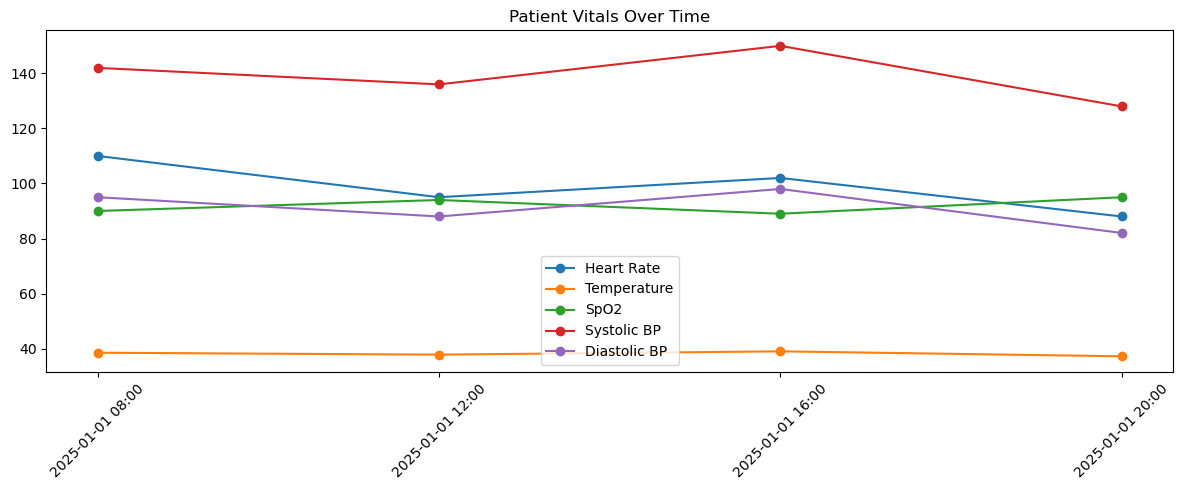

In [9]:
plt.figure(figsize=(12,5))

plt.plot(vitals["timestamp"], vitals["hr"], marker="o", label="Heart Rate")
plt.plot(vitals["timestamp"], vitals["temp"], marker="o", label="Temperature")
plt.plot(vitals["timestamp"], vitals["spo2"], marker="o", label="SpO2")
plt.plot(vitals["timestamp"], vitals["systolic"], marker="o", label="Systolic BP")
plt.plot(vitals["timestamp"], vitals["diastolic"], marker="o", label="Diastolic BP")

plt.xticks(rotation=45)
plt.title("Patient Vitals Over Time")
plt.legend()
plt.tight_layout()
plt.show()


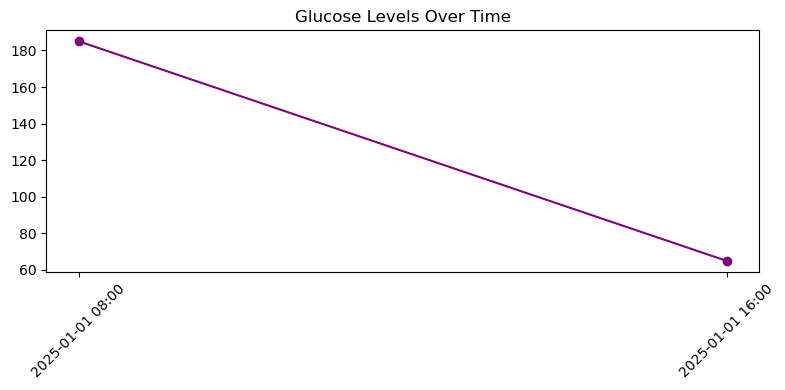

In [10]:
plt.figure(figsize=(8,4))

plt.plot(labs["timestamp"], labs["glucose"], marker="o", color="purple")
plt.title("Glucose Levels Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Summary

This notebook demonstrates:

- Loading vitals and labs data  
- Applying CDS clinical rules  
- Generating alerts  
- Exporting alerts as FHIR DetectedIssue resources  
- Visualizing patient trends  

This simulates how EHR-based CDS systems function.
